# Mixing matrices

By default the Summer compartmental model assumes that each person in the model comes into contact with every other person at the same rate (homogeneous mixing). This isn't always true. It may be the case, for example, that children tend to interact more with other children, and less with the elderly (with-like or assortative mixing). This difference in social mixing can be expressed and modelled using a "mixing matrix". A NxN matrix which defines how each N strata of a stratification interact and may infect each other.


For example, in a 'child'/'adult' stratification, we could have the following mixing matrix (arbitrary numbers):

| | child | adult |
| --- | --- | --- |
| child | 0.2 | 0.3 |
| adult | 0.5 | 0.7 |


In this mixing matrix, the columns are the infectors and the rows the infected. So the above matrix represents the following infector -> infected relationships:

| | child | adult |
| --- | --- | --- |
| **child** | child -> child | adult -> child |
| **adult** | child -> adult | adult -> adult |


This worked example may clarify. We will calculate the frequency-dependent infection rates for adults and children using the above mixing matrix. Assume the following scenario:

- 1000 people, 10 infected, 990 susceptible
- 80% of the population is adults, 20% are children
- So, 800 adults with 792 susceptible and 8 infected; and
- 200 children with 198 susceptible and 2 infected


```python
child_force_of_inf = 0.2 * 2 / 200 + 0.3 * 8 / 800
adult_force_of_inf = 0.5 * 2 / 200 + 0.7 * 8 / 800

# Here we assume the contact rate accounts for the use of a mixing matrix .
child_inf_rate = contact_rate * child_force_of_inf * 198
adult_inf_rate = contact_rate * adult_force_of_inf * 792
```

## Using a mixing matrix

Let's start by defining some code to build a model and plot the results:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from summer import CompartmentalModel

def build_model():
    """Returns a model for the mixing matrix examples"""
    model = CompartmentalModel(
        times=[0, 20],
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": 990, "I": 10})
    model.add_infection_frequency_flow(name="infection", contact_rate=2, source="S", dest="I")
    model.add_transition_flow(name="recovery", fractional_rate=1/3, source="I", dest="R")
    model.add_death_flow(name="infection_death", death_rate=0.05, source="I")
    return model

    
def plot_compartments(model, times=[]):
    """Plot model compartment sizes over time"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
    for i in range(model.outputs.shape[1]):
        ax.plot(model.times, model.outputs.T[i])

    for t in times:
        ax.axvline(x=t, color='k', linestyle='--', alpha=0.3)

    ax.set_title("SIR Model Outputs")
    ax.set_xlabel("Days")
    ax.set_ylabel("Compartment size")
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start + 1, end, 5))
    ax.legend([str(c) for c in model.compartments], loc='upper right')
    plt.show()

For starters let's see what our 'vanilla' SIR model looks like when not stratified at all

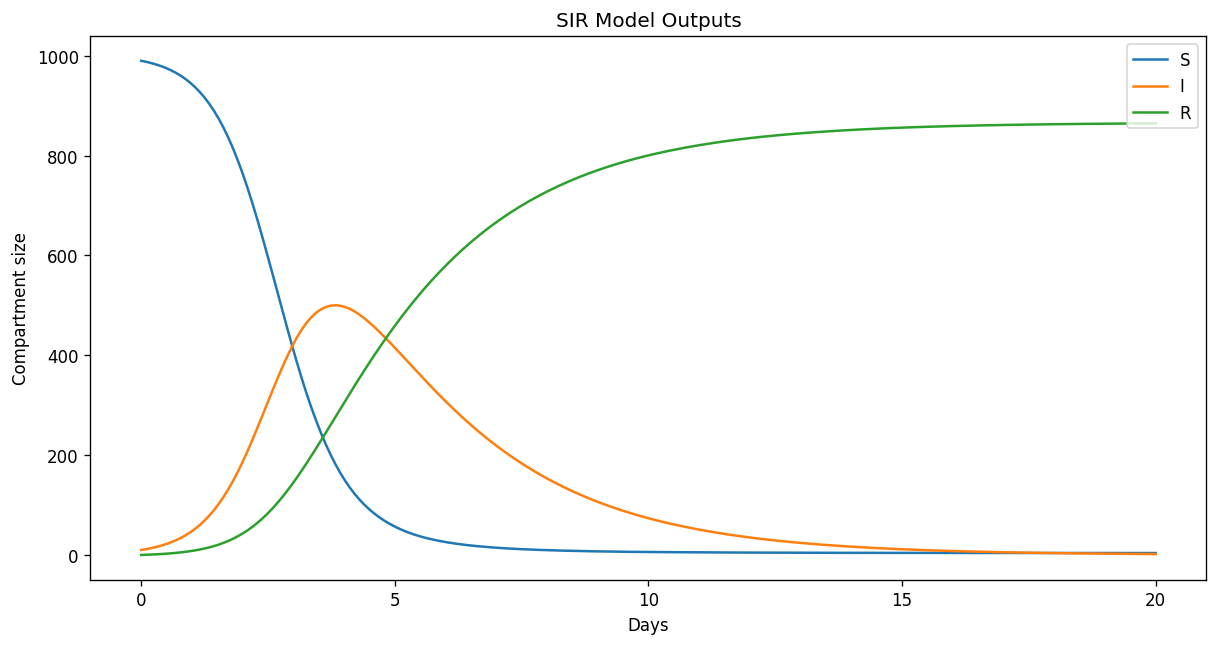

In [2]:
# Build and run model without any stratification
model = build_model()
model.run()
plot_compartments(model)

A mixing matrix can be added to any "full" stratificiation: which is one that affects all compartments.

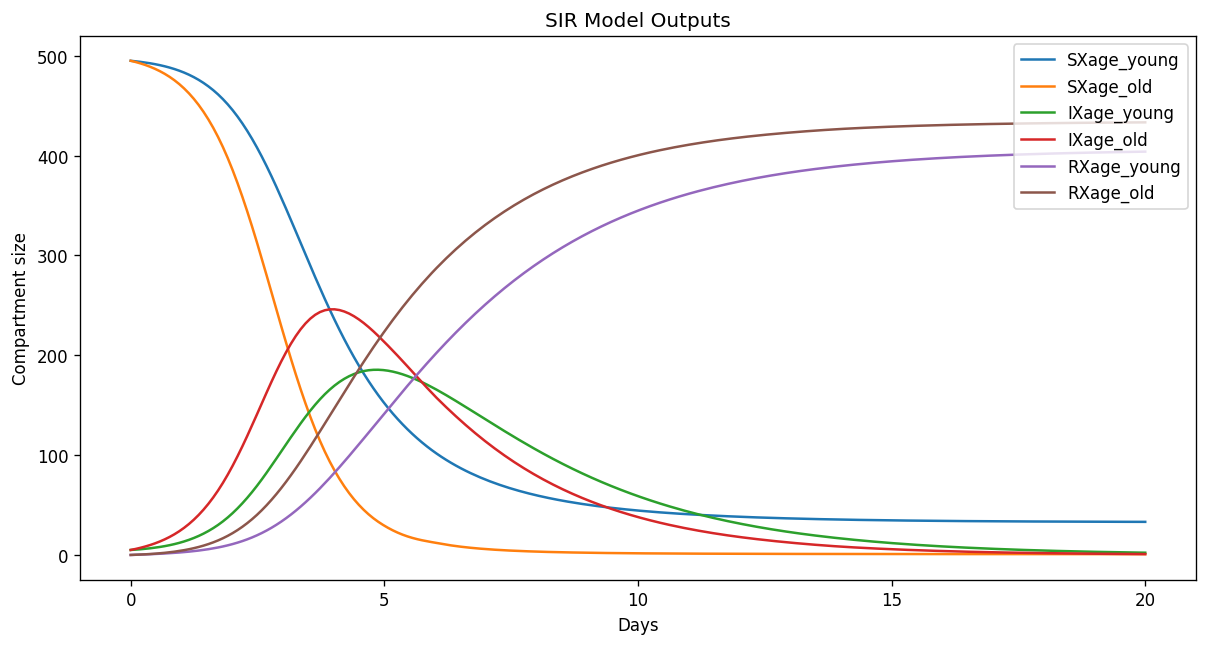

In [3]:
import numpy as np
from summer import Stratification

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
# Implicitly there is a 50-50 split between young and old.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# Define a NxN (in this case 2x2) mixing matrix.
# The order of the rows/columns will be the same as 
# the order of the strata passed to the Stratification
age_mixing_matrix = np.array([
    [0.2, 0.3],
    [0.5, 0.7],
]) 

# Add the mixing matrix to the stratification
strat.set_mixing_matrix(age_mixing_matrix)

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run()
plot_compartments(model)

## Time-varying mixing matrices

You can specify a mixing matrix that varies over time, by using a function of time that returns a mixing matrix:

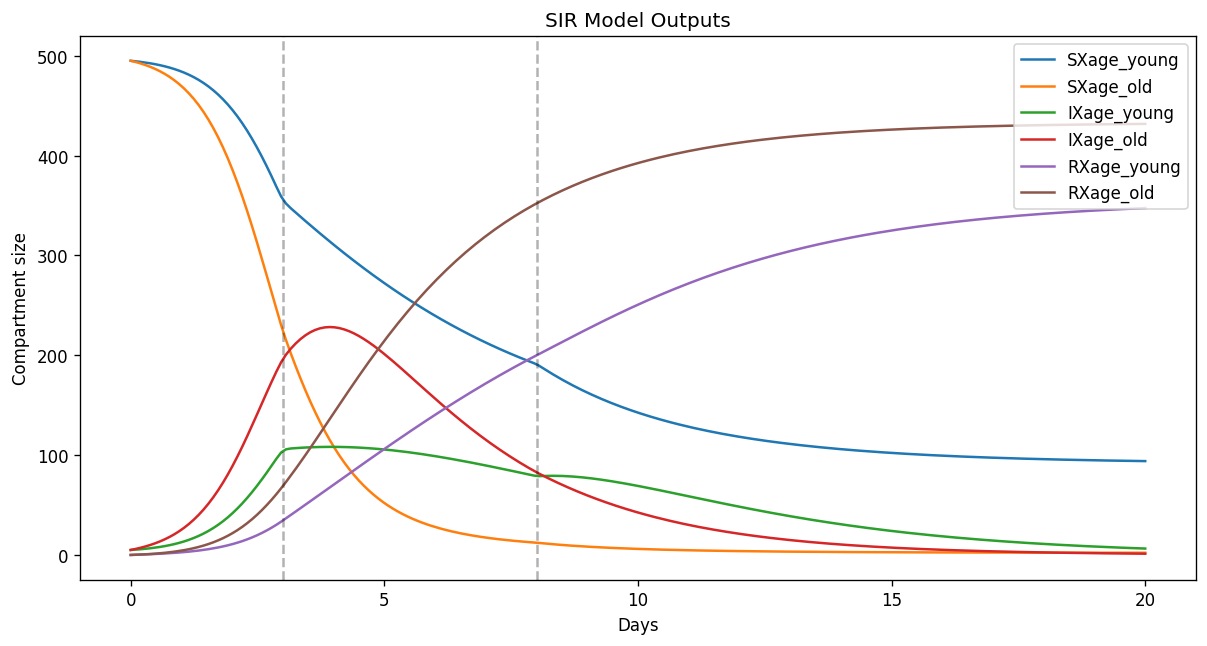

In [4]:
import numpy as np
from summer import Stratification

# Create a stratification named 'age', applying to all compartments, which
# splits the population into 'young' and 'old'.
strata = ["young", "old"]
strat = Stratification(name="age", strata=strata, compartments=["S", "I", "R"])

# An age mixing matrix for 'normal' social mixing
normal_mixing_matrix = np.array([
    [0.2, 0.3],
    [0.5, 0.7],
]) 

# An age mixing matrix for 'age lockdown': 
#  - no interaction between young and old
#  - increased interaction inside each group
lockdown_mixing_matrix = np.array([
    [0.3, 0.0],
    [0.0, 0.8],
]) 

start_lockdown = 3  # Day 3
end_lockdown = 8  # Day 8

# Define heterogeneous mixing as a function of time.
def get_age_mixing_matrix(time):
    if time <= start_lockdown:
        # Pre lockdown, normal mixing
        return normal_mixing_matrix
    if time <= end_lockdown:
        # Use lockdown mixing
        return lockdown_mixing_matrix
    else:
        # Then after lockdown we go back to normal mixing again
        return normal_mixing_matrix

# Add the mixing matrix to the stratification
strat.set_mixing_matrix(get_age_mixing_matrix)

# Build and run model with the stratification we just defined
model = build_model()
model.stratify_with(strat)
model.run('rk4', step_size=0.1)
plot_compartments(model, times=[start_lockdown, end_lockdown])

## Multiple mixing matrices for multiple stratifications

You can set mixing matrices for multiple stratifications. You also have the option not to. A key assumption is that these two types of mixing are independent. For example, below we assume that there is heterogeneous mixing between young and old agegroup as well as mixing between urban and rural residents, but the model will assume that the way that young and old people mix in rural areas is the same as the way that young and old people mix in urban areas.

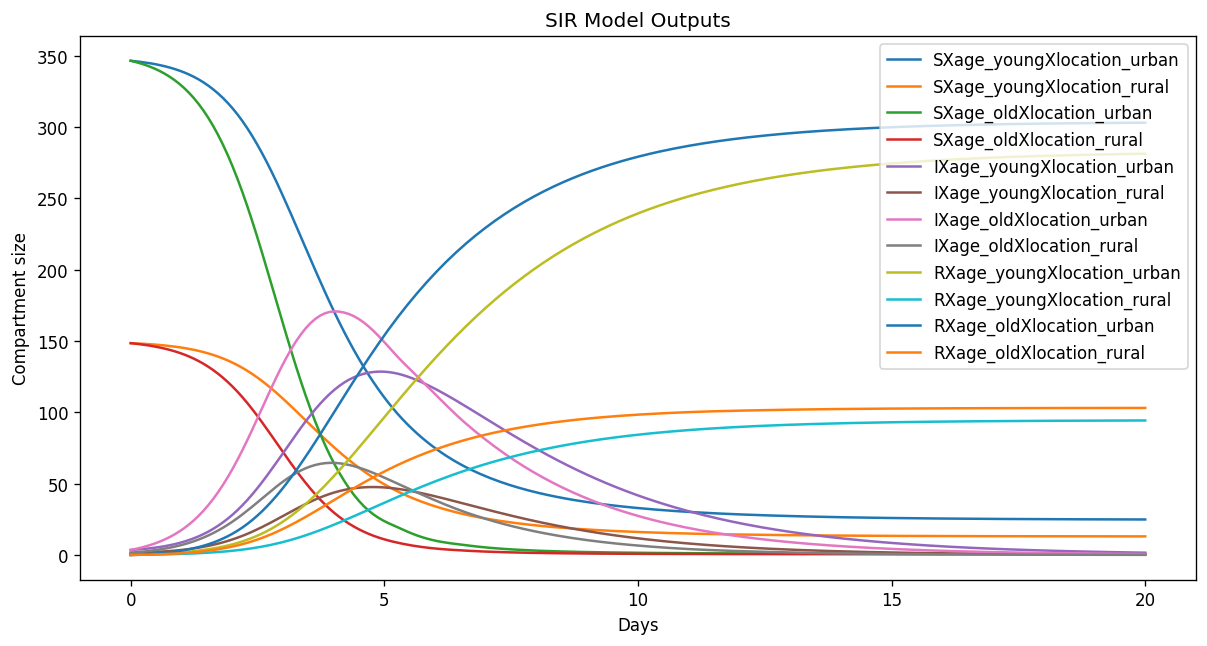

In [5]:
from summer import Stratification, Multiply, Overwrite

# Age stratification with young/old mixing
age_strata = ["young", "old"]
age_strat = Stratification(name="age", strata=age_strata, compartments=["S", "I", "R"])
age_mixing_matrix = np.array([
    [0.2, 0.3],
    [0.5, 0.7],
]) 
age_strat.set_mixing_matrix(age_mixing_matrix)


# Location stratification with urban/rural mixing
loc_strata = ["urban", "rural"]
loc_strat = Stratification(name="location", strata=loc_strata, compartments=["S", "I", "R"])
# Rural people have worse health care, higher mortality rates,
loc_strat.add_flow_adjustments("infection_death", {
    "urban": None,
    "rural": Multiply(3),
})
loc_strat.set_population_split({"urban": 0.7, "rural": 0.3})
loc_mixing_matrix = np.array([
    [0.8, 0.2],
    [0.2, 0.8],
]) 
loc_strat.set_mixing_matrix(loc_mixing_matrix)


# Build and run model with the stratifications we just defined
model = build_model()
# Apply age, then location stratifications 
model.stratify_with(age_strat)
model.stratify_with(loc_strat)
model.run()
plot_compartments(model)

The combined age and location matrix is the Kronecker product of the age and location matrices. We can visualize it here:

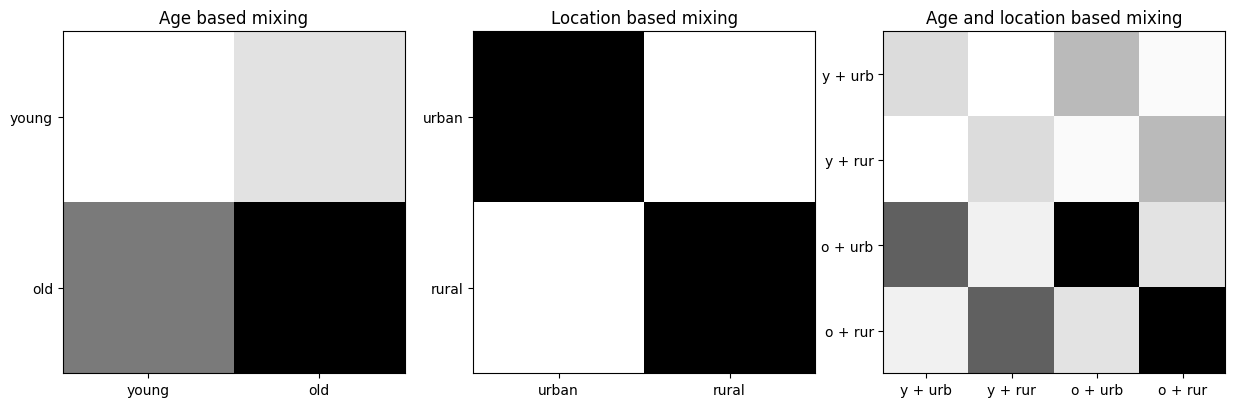

In [6]:
import itertools

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100)
combined_strata = [
    f"{age[0]} + {loc[:3]}" for age, loc 
    in itertools.product(age_strata, loc_strata)
]
combined_matrix = model._get_mixing_matrix(0)
plots = [
    ['Age based mixing', age_strata, age_strat.mixing_matrix],
    ['Location based mixing', loc_strata, loc_strat.mixing_matrix],
    ['Age and location based mixing', combined_strata, combined_matrix],

]
for ax, (title, strata, matrix) in zip(axes, plots):
    ax.set_title(title)
    ax.set_xticks(np.arange(len(strata)))
    ax.set_yticks(np.arange(len(strata)))
    ax.set_xticklabels(strata)
    ax.set_yticklabels(strata)
    ax.imshow(matrix, cmap="Greys")

plt.show()

## Prem et al. mixing matrices based on age and location

You can obtain estimated mixing matrices from [Projecting social contact matrices in 152 countries using contact surveys and demographic data](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697#sec020) by Prem et al. in PLOS Computational Biology in 2017.

This paper is accompanied by age and location specific mixing matrices for 152 countries. You can download the matrices as Excel spreadsheets [here](https://doi.org/10.1371/journal.pcbi.1005697.s002). The paper provides mixing matrices for 5 location types:

- home
- school
- work
- other_locations
- all_locations

The rows and columns indices of each matrix represent a 5 year age bracket from 0-80, giving us a 16x16 matrix. 

A more recent version of these social mixing matrices can be obtained from [Kiesha Prem's GitHub](https://github.com/kieshaprem/synthetic-contact-matrices)